# Chapter 12: Applying Quantum Algorithms

In [1]:
# Load Helper file
%run helper_file_1.0.ipynb

The number of bitstrings is: 1024
The counts are: {'000': 527, '111': 497}


In [2]:
# Initialize the 3-qubit quantum circuit
# Set the state '110'
s = '110'
num_qubits = len(s)
qc = QuantumCircuit(num_qubits)

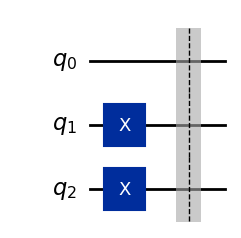

In [3]:
# Set reverse ordering
s = s[::-1] 

# Construct the state 110
for idx in range(num_qubits):
    if s[idx] == '1':
        qc.x(idx)    

qc.barrier()
qc.draw(output='mpl')

In [4]:
# Import the value pi for our rotations
from numpy import pi

# Always start from the most significant qubit, 
# in this case it's q2.
# Step 1, add a Hadamard gate
qc.h(2)


In [5]:
# Step 2, add CROT gates from most significant qubit 
qc.cp(pi/2, 1, 2)


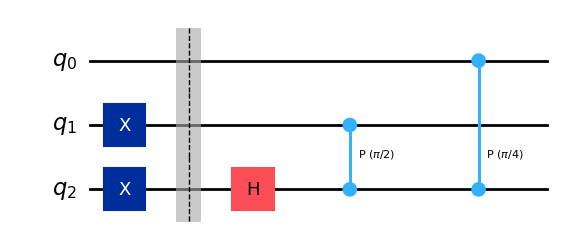

In [6]:
# Step 3, add another CROT from 2 to the next qubit down,
# while doubling the phase denominator
qc.cp(pi/4, 0, 2)

# Draw the circuit
qc.draw(output='mpl')


In [7]:
# Now that we finished from 2 down to 0
# We'll drop to the next least significant qubit and start again, 
# Step 1, add a Hadamard gate
qc.h(1)


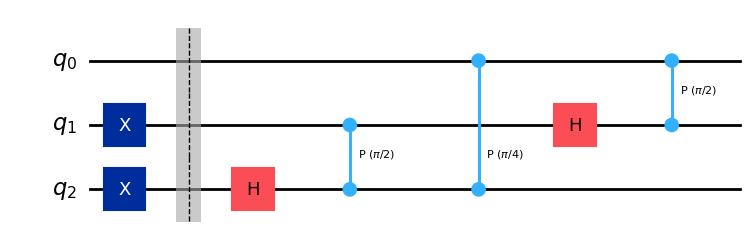

In [8]:
# Step 2, add Control Rotation (CROT) gates from most significant towards 
# least significant starting a pi/2, and doubling the denominator 
# as you go down each qubit. 
qc.cp(pi/2, 0, 1)

# Draw the circuit
qc.draw(output='mpl')


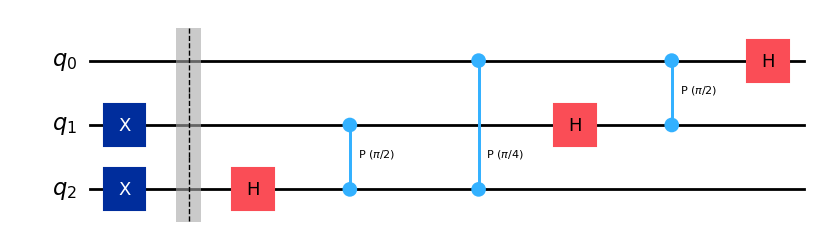

In [9]:
# Step 1, add a Hadamard gate
qc.h(0)
# Since we are at the least significant qubit, we are done!

# Draw the circuit
qc.draw(output='mpl')


In [10]:
# Define a function which will add the swap gates to the outer 
# pair of qubits
def add_swap_gates(qc_swaps, qubits):
    for qubit in range(qubits//2):
        qc_swaps.swap(qubit, qubits-qubit-1)
    return qc_swaps


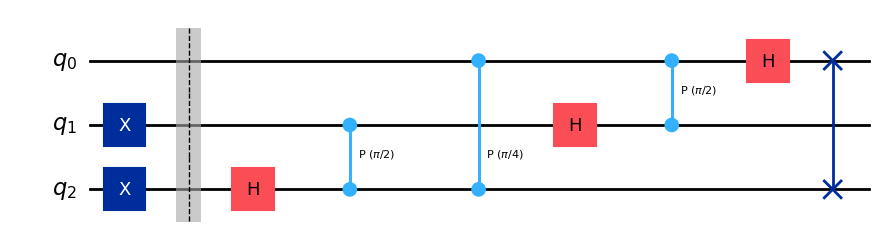

In [11]:
qft_circuit = add_swap_gates(qc, num_qubits)
qft_circuit.draw(output='mpl')


In [34]:
# Let's define two functions to run our circuits on both a Sampler and a quantum computer

def run_on_sampler(circuit, shots):
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime import SamplerV2 as Sampler
    from qiskit_ibm_runtime.fake_provider import FakeManilaV2
     
    # Run the sampler job locally using FakeManilaV2
    fake_manila = FakeManilaV2()
    pass_manager = generate_preset_pass_manager(backend=fake_manila, optimization_level=1)
    transpiled_qc = pass_manager.run(circuit)
     
    # To ensure we get fixed results, set seed
    options = {"simulator": {"seed_simulator": 10258}}
    sampler = Sampler(mode=fake_manila, options=options)
     
    result = sampler.run([transpiled_qc], shots=shots).result()[0]
    return result

# Run on the least busy quantum computer
def run_on_qc(circuit, shots):
    # At the time of this writing, the latest version of Sampler was SamplerV2. 
    #You may need to update if version numbers have dropped. 
    from qiskit_ibm_runtime import SamplerV2 as Sampler2
    # Assign least busy device to backend
    backend = service.least_busy(min_num_qubits=circuit.num_qubits, simulator=False, operational=True)
    #Print the least busy device
    print('The least busy device: {}'.format(backend))
    #result = {}

    # Transpile the circuit using the preset pass manager
    transpiler = generate_preset_pass_manager(backend=backend, optimization_level=3)
    transpiled_qc = transpiler.run(circuit)

    sampler = Sampler2(backend)
    job = sampler.run([transpiled_qc], shots=shots)
    job_result = job.result()

    # Extract the results 
    result = job_result[0]
        
    return result 

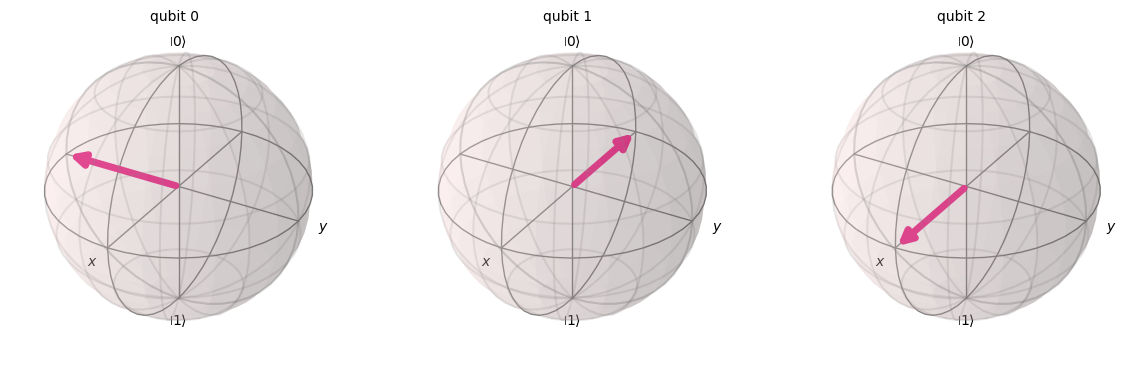

In [16]:
# Get the state vector simulator to view our final QFT state
from qiskit.quantum_info import Statevector
statevector = Statevector(qft_circuit)
plot_bloch_multivector(statevector)


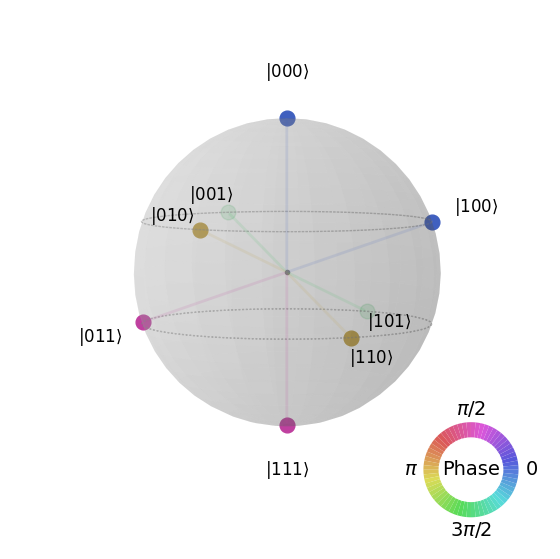

In [17]:
plot_state_qsphere(statevector)

# Grover's Algorithm
Implementing Grover's algorithm

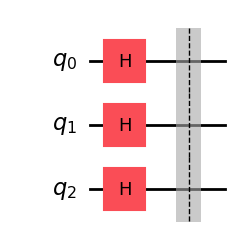

In [18]:
# Set the state we wish to search 
N = '110'
num_qubits = len(N)

# Create the quantum circuit 
qc = QuantumCircuit(num_qubits)

# Set all qubits in superposition
qc.h(range(num_qubits))
qc.barrier()

#Draw the circuit
qc.draw(output='mpl')


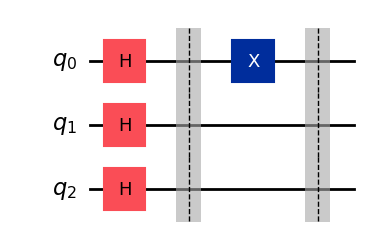

In [19]:
# Reverse the state so it’s in proper qubit ordering
N = N[::-1]

# Encode N into our circuit
for idx in range(num_qubits):
    if N[idx] == '0':
        qc.x(idx)
qc.barrier()

# Draw the circuit
qc.draw(output='mpl')


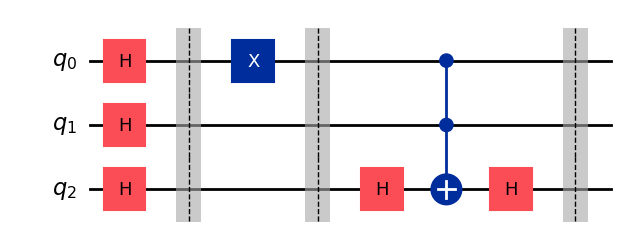

In [20]:
# Create the Grover oracle for our 3-qubit quantum circuit
qc.h(2)
qc.ccx(0, 1, 2)
qc.h(2)
qc.barrier()

# Draw the circuit
qc.draw(output='mpl')


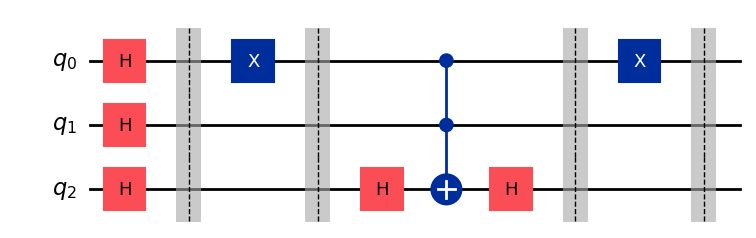

In [21]:
# Reset the value after the oracle
for idx in range(num_qubits):
    if N[idx] == '0':
        qc.x(idx)
qc.barrier()

# Draw the circuit
qc.draw(output='mpl')


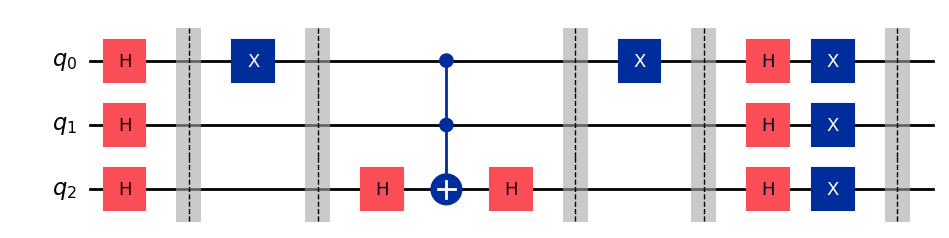

In [22]:
# Set all qubits in superposition
qc.h(range(num_qubits))
qc.x(range(num_qubits))
qc.barrier()

# Draw the circuit
qc.draw(output='mpl')


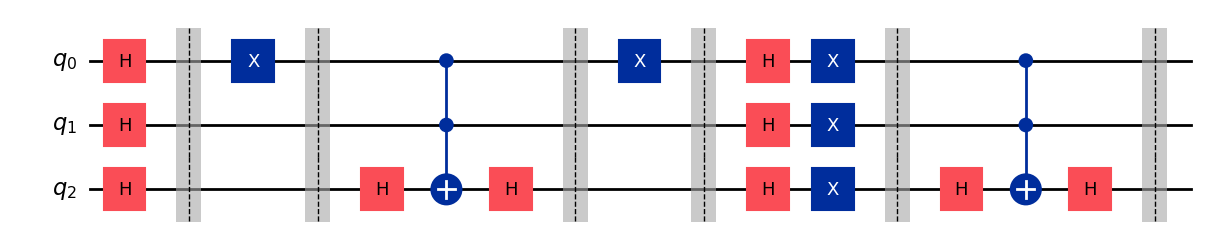

In [23]:
# Apply another oracle, same as the previous, 
qc.h(2)
qc.ccx(0, 1, 2)
qc.h(2)
qc.barrier()

# Draw the circuit
qc.draw(output='mpl')


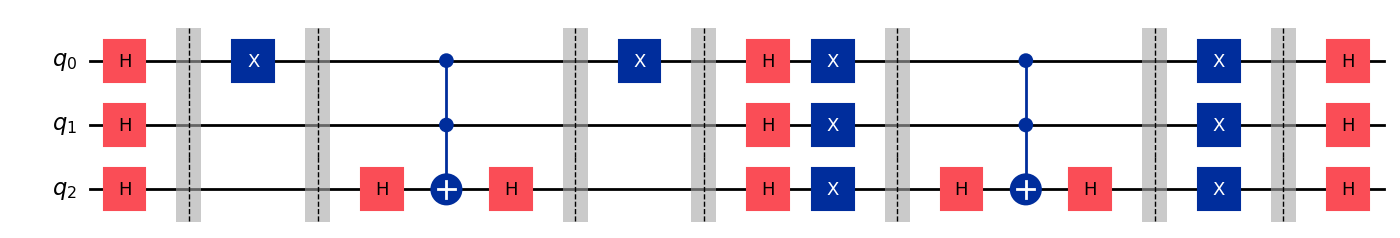

In [24]:
# Reapply the X rotations on all qubits
qc.x(range(num_qubits))

qc.barrier()

# Reapply Hadamard gates to all qubits
qc.h(range(num_qubits))

# Draw the circuit
qc.draw(output='mpl')


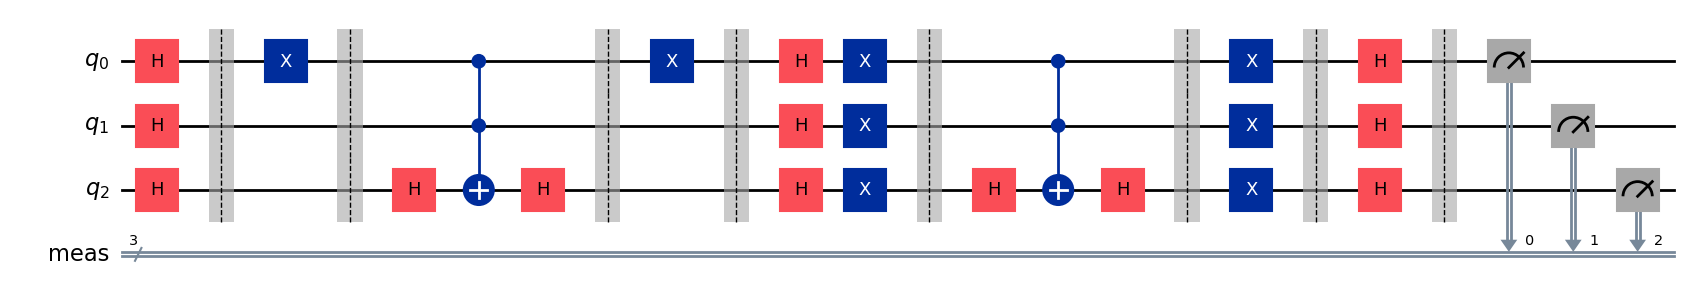

In [25]:
# Add measurement operators
qc.measure_all()

# Draw the circuit
qc.draw(output='mpl')



{'010': 274, '110': 2237, '000': 198, '100': 499, '101': 175, '111': 238, '001': 191, '011': 188}


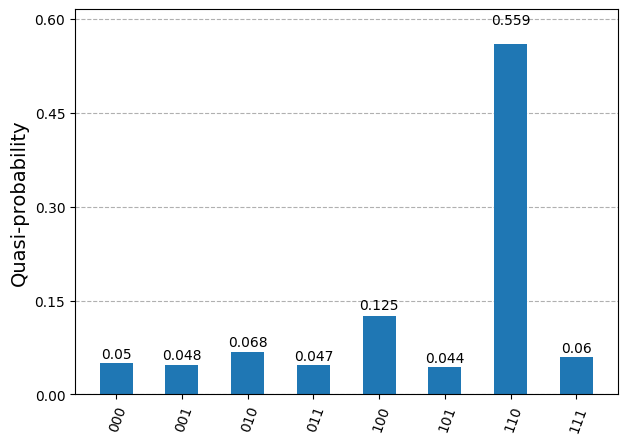

In [26]:
 
# Print and plot results
print(counts)
plot_distribution(counts)

### Run Grover's algorithm on a quantum computer

In [27]:
# Run the circuit on the least busy quantum computer
backend = service.least_busy(min_num_qubits = num_qubits, simulator=False, operational=True)
print("Set backend: ", backend)

Set backend:  <IBMBackend('test_eagle_us-east')>


In [35]:
# Run the circuit on the backend
shots = 1000
results = run_on_qc(qc, shots)
print(results)


The least busy device: <IBMBackend('test_eagle_us-east')>
SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1000, num_bits=3>)), metadata={'circuit_metadata': {}})


In [36]:
counts = results.data.meas.get_counts()
# Print results
print(counts)

{'001': 147, '110': 125, '011': 118, '010': 111, '111': 130, '101': 118, '000': 125, '100': 126}


In [33]:
!pip list | grep qiskit

qiskit                    1.2.0
qiskit-aer                0.15.0
qiskit-ibm-runtime        0.31.0
